______________________

# A Very Friendly Introduction to  machine learning and application: Unstructured data

## News headlines classification

- The purpose of this project is to correctly classify news headlines by training models on the News Aggregator Dataset found in the UCI ML Repository: http://archive.ics.uci.edu/ml/datasets/News+Aggregator. 

Author: Thabang Mashinini
_____________________

 1. Let's begin by importing the necessary libraries.

In [1]:
# array manipulation
import numpy as np
# data processing
import pandas as pd

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# for machine leanring
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn_evaluation.plot import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
plt.rcParams['figure.figsize'] = (20.0, 10.0)

_________________________

# Data

Let's view the data
_______________________

In [2]:
df = pd.read_csv('data/uci-news-aggregator.csv')
# first 3 rows
df.head(3)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550


In [8]:
# last 3 rows
df.tail(3)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
422416,422935,Child who swallowed battery to have reconstruc...,http://www.newsnet5.com/news/local-news/child-...,NewsNet5.com,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.newsnet5.com,1409229190771
422417,422936,Phoenix boy undergoes surgery to repair throat...,http://www.wfsb.com/story/26368078/phoenix-boy...,WFSB,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wfsb.com,1409229191071
422418,422937,Phoenix boy undergoes surgery to repair throat...,http://www.cbs3springfield.com/story/26368078/...,WSHM-TV,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.cbs3springfield.com,1409229191565


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422419 entries, 0 to 422418
Data columns (total 8 columns):
ID           422419 non-null int64
TITLE        422419 non-null object
URL          422419 non-null object
PUBLISHER    422417 non-null object
CATEGORY     422419 non-null object
STORY        422419 non-null object
HOSTNAME     422419 non-null object
TIMESTAMP    422419 non-null int64
dtypes: int64(2), object(6)
memory usage: 25.8+ MB


### The columns included in this dataset are:

- ID        : the numeric ID of the article
- TITLE     : the headline of the article
- URL       : the URL of the article
- PUBLISHER : the publisher of the article
- STORY     : alphanumeric ID of the news story that the article discusses
- HOSTNAME  : hostname where the article was posted
- TIMESTAMP : approximate timestamp of the article's publication, given in Unix time (seconds since midnight on Jan 1, 1970)
- CATEGORY  : the category of the news item; one of:
- b         : business
- t         : science and technology
- e         : entertainment
- m         : health 

________________
# Data Wrangling
_______________

#### Dealing with missing values

In [4]:
# Columns with missing values
df.isnull().any()

ID           False
TITLE        False
URL          False
PUBLISHER     True
CATEGORY     False
STORY        False
HOSTNAME     False
TIMESTAMP    False
dtype: bool

In [5]:
# Rows with missing values
df[df.isnull().any(1)]

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
4556,4557,Federal Prosecutors Want Cash From Denver Pot ...,http://denver.cbslocal.com/2014/03/10/federal-...,NaN,b,d__jcKruuebDhTMfkhbUJpI3MBjEM,denver.cbslocal.com,1394565833004
14203,14204,Honda Recalls Nearly 900000 Minivans,http://dfw.cbslocal.com/2014/03/16/honda-recal...,NaN,t,dRxWun-PlDEkGpMTSH5m3mrA0rO2M,dfw.cbslocal.com,1395062073951


In [6]:
# How many missing values do we have for each column?
df.isnull().sum()

ID           0
TITLE        0
URL          0
PUBLISHER    2
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

In [7]:
df['PUBLISHER']   = df['PUBLISHER'].replace('Unknown', np.nan)

______________________
# Data Visualization 
_____________________

Before moving forward, Let's quickly see the distribution of news categories in this dataset via a pie chart.

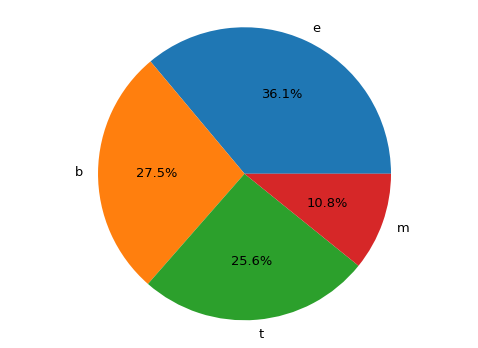

In [8]:
df.CATEGORY.value_counts().plot(kind='pie', 
                                  figsize=(8,6), 
                                  fontsize=13, 
                                  autopct='%1.1f%%', 
                                  wedgeprops={'linewidth': 5}
                                  )
plt.axis('off')
plt.axis('equal');

- Entertaiment rocks baby!!

### Now lets find out the hot topics in each news category. We will use word cloud, before that let:

- Remove all punctuation from the news titles.
- Convert all words into lower case to ensure that similar instances of capitalized and uncaapitalized words aren't distinctly counted.


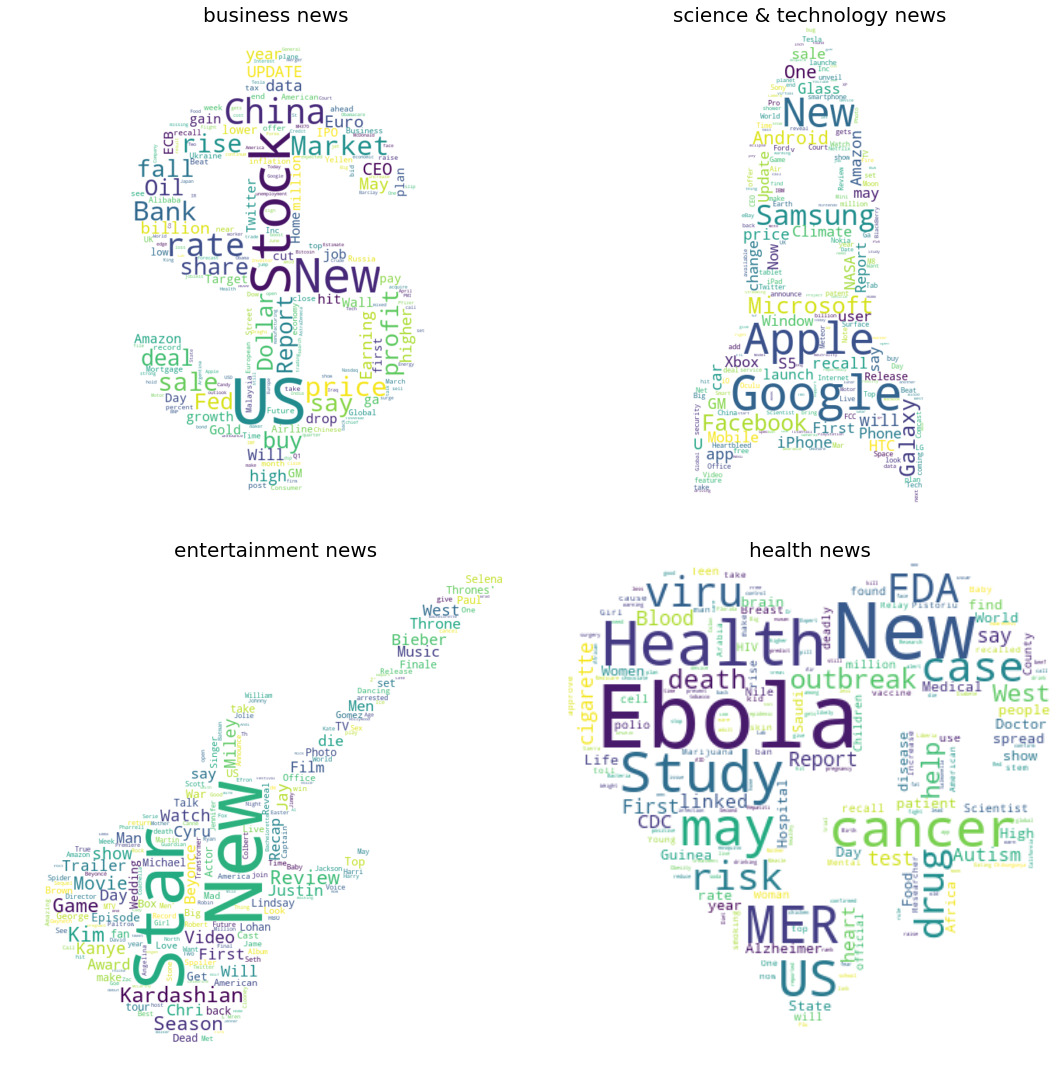

In [27]:
# necessary libraries for wordcloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

# create dataframe for each category
b_news = df.loc[df['CATEGORY'] == 'b'] # business
t_news = df.loc[df['CATEGORY'] == 't'] # science and technology
e_news = df.loc[df['CATEGORY'] == 'e'] # entertainment 
m_news = df.loc[df['CATEGORY'] == 'm'] # health

# convert news titles to usable strings for the word clouds
b_title = b_news['TITLE'].to_string()
t_title = t_news['TITLE'].to_string()
e_title = e_news['TITLE'].to_string()
m_title = m_news['TITLE'].to_string()

# import images and make them usable by word cloud
b_image = np.array(Image.open('images/business.jpg'))
t_image = np.array(Image.open('images/scitech.jpg'))
e_image = np.array(Image.open('images/entertainment.jpg'))
m_image = np.array(Image.open('images/health.jpg'))


fig = plt.figure(figsize=(15,15))

# setting stop-words, so words like "the" and "it" are ignored
stopwords = set(STOPWORDS)

# business news cloud
ax1 = fig.add_subplot(221)
b_wordcloud = WordCloud(background_color='white', mask=b_image, collocations=False, stopwords=stopwords).generate(b_title)
ax1.imshow(b_wordcloud, interpolation='bilinear')
ax1.set_title('business news', size=20)
ax1.axis('off')
plt.savefig('Business_news.png')

# science and technology news cloud
ax2 = fig.add_subplot(222)
t_wordcloud = WordCloud(background_color='white', mask=t_image, collocations=False, stopwords=stopwords).generate(t_title)
ax2.imshow(t_wordcloud, interpolation='bilinear')
ax2.set_title('science & technology news', size=20)
ax2.axis('off')
plt.savefig('Ccience-technology-news.png')

# entertainment news cloud
ax3 = fig.add_subplot(223)
e_wordcloud = WordCloud(background_color='white', mask=e_image, collocations=False, stopwords=stopwords).generate(e_title)
ax3.imshow(e_wordcloud, interpolation='bilinear')
ax3.set_title('entertainment news', size=20)
ax3.axis('off')
plt.savefig('Entertainment-news.png')

# health news cloud
ax4 = fig.add_subplot(224)
m_wordcloud = WordCloud(background_color='white', mask=m_image, collocations=False, stopwords=stopwords).generate(m_title)
ax4.imshow(m_wordcloud, interpolation='bilinear')
ax4.set_title('health news', size=20)
ax4.axis('off')
plt.savefig('Health-news.png')

fig.tight_layout()

In [13]:
# !pip install  wordcloud

### Some of the most hot topics in news headlines (at least in 2014) for each of the four categories have been:

- Business: "stock", "US", "China","Market"
- Entertainment: "star", "Kardashian", "Bieber", "Miley"
- Science & Technology: "Facebook", "Google", "new","Samsung"
- Health: "study", "Ebola", "cancer","Outbreak"

This is reassuring. When we do use a function to return the categories of various headlines, the categories returned will make sense (if everything goes well).


___________________
# Feature Engineering: Introduction to natural language processing (NLP)
______________________

- We cannot work with text directly when using machine learning algorithms.
- Instead, we need to convert the text to numbers.
- Text data requires special preparation before you can start using it for predictive modeling
- The text must be parsed to remove words, called tokenization
- Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization)

#### Introduction to bag of words

- A bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:
    - A vocabulary of known words.
    - A measure of the presence of known words.
- It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document 

### Example:
- Consider the following corpus:

    - **“It was the best of times”**
    - **“It was the worst of times”**
    - **“It was the age of wisdom”**
    - **“It was the age of foolishness”**

- We treat each sentence as a separate document and we make a list of all words from all the four documents excluding the punctuation. We get,

    - **‘It’, ‘was’, ‘the’, ‘best’, ‘of’, ‘times’, ‘worst’, ‘age’, ‘wisdom’, ‘foolishness’**
    
- The next step is the create vectors. Vectors convert text that can be used by the machine learning algorithm.

  - We take the first document — **“It was the best of times”** and we check the frequency of words from the 10 unique words.
  
    - **“it” = 1**
    - **“was” = 1**
    - **“the” = 1**
    - **“best” = 1**
    - **“of” = 1**
    - **“times” = 1**
    - **“worst” = 0**
    - **“age” = 0**
    - **“wisdom” = 0**
    - **“foolishness” = 0**
    

    
- Rest of the documents will be:
    
    ______________________________________
    
    Word_vector  = [**‘It’, ‘was’, ‘the’, ‘best’, ‘of’, ‘times’, ‘worst’, ‘age’, ‘wisdom’, ‘foolishness’**]
    ______________________________________
    
    
 - **“It was the best of times”      = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]**
 - **“It was the worst of times”     = [1, 1, 1, 0, 1, 1, 1, 0, 0, 0]**
 - **“It was the age of wisdom”      = [1, 1, 1, 0, 1, 0, 0, 1, 1, 0]**
 - **“It was the age of foolishness” = [1, 1, 1, 0, 1, 0, 0, 1, 0, 1]**
  
- In this approach, each word or token is called a “gram”.

In [15]:
# convert data to vectors
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['TITLE'])
y = df['CATEGORY']

_____________________
# Modeliing: Introduction Machine learning
____________________


- The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

In [17]:
# import necessary packages
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
# import scikitplot as skplt
# !pip install scikit-plot

In [18]:
# split the data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [19]:
def model(X_train,y_train,X_test, y_test, model=MultinomialNB(alpha=1) ):
    
    model.fit(X_train, y_train)
    print('Model accuracy:' ,model.score(X_test, y_test))
    return model.predict(X_test)

In [22]:
print('Naive Bayes Model')
NB = model(X_train,y_train,X_test, y_test, model =MultinomialNB(alpha=1))

Naive Bayes Model
('Model accuracy:', 0.9277180689045658)


In [24]:
print('Decision Tree Model')
dt = model(X_train,y_train,X_test, y_test, model =tree.DecisionTreeClassifier())

Decision Tree Model
('Model accuracy:', 0.9197402269463252)


- An accuracy of 92.8% is pretty good. Let's see the confusion matrix to observe the model's behavior.

In [25]:
skplt.metrics.plot_confusion_matrix(y_test, NB, labels = ['b','e','m','t']).grid(False)

NameError: name 'skplt' is not defined

- A majority of the misclassifications occur between the Business and Science & Technology categories, as they together account for over 4000 instanses of incorrect classification.

- Let's see if a stronger model can fix this.

_________________
# Introduction to hyper parameterization
________________


In [ ]:
sgd = SGDClassifier(n_jobs=-1, n_iter=10, random_state=1234)

# hyperparameters for tuning
sgd_grid = [{'loss': ['hinge', 'log', 'squared_hinge'],
             'alpha': [0.0001, 0.0001, 0.00001]}]

# grid search with cross validation
sgd_search = GridSearchCV(estimator=sgd, param_grid=sgd_grid, cv=5, refit=True)
sgd_search.fit(X_train, y_train)

In [ ]:
sgd_search.best_params_

In [ ]:
sgd_search.best_estimator_.score(X_test, y_test)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, sgd_search.best_estimator_.predict(X_test), labels = ['b','e','m','t']).grid(False)

- Looks like it's not so easy to correctly classify news within Business and Science & Technology categories. While the number of misclassified samples are lower - at roughly 3300 - it is possible that a degree of preprocessing or picking a better estimator could help improve model accuracy. 

_____________

# Product

____________

In [ ]:
# title-category function
def title_to_category(title):
    #  create a dictionary
    categories = {'b' : 'business', 
                  't' : 'science and technology', 
                  'e' : 'entertainment', 
                  'm' : 'health'}
    
    vectorize_text = vectorizer.transform([title])
    predicter = sgd_search.best_estimator_.predict(vectorize_text)
    return categories[predicter[0]]

______

____________________
[Business-today-2019](https://www.businesslive.co.za/bd/companies/energy/2019-03-26-total-will-face-worlds-fastest-ocean-current-when-it-drills-for-oil-off-sas-coast/)
___________________

In [ ]:
title_to_category("Total will face world’s fastest ocean current when it drills for oil off SA’s coast.")

____________________
[TB-Wits-news-2019](http://www.wits.ac.za/news/latest-news/opinion/2019/2019-03/major-battles-have-been-won-against-tb-but-the-war-isnt-over.html)
___________________

In [ ]:
title_to_category("Major battles have been won against TB. But the war isn’t overe.")

______________________
[new-discovered-galaxies-2019](https://futurism.com/the-byte/galaxies-300000-added-universe)
_______________

In [ ]:
title_to_category("Scientists Just Discovered 300,000 New Galaxies.")

In [ ]:
title_to_category("Consert.")